**Its a notebook of BERT along with Dense Layer as Feedforward Network: Bert-2**

In [ ]:
!nvidia-smi

Wed Jul  7 02:43:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Library

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install -q tfds-nightly

     |████████████████████████████████| 4.3MB 12.6MB/s 
     |████████████████████████████████| 1.6MB 12.5MB/s 
     |████████████████████████████████| 38.2MB 130kB/s 
     |████████████████████████████████| 215kB 47.6MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 1.2MB 45.8MB/s 
     |████████████████████████████████| 686kB 47.1MB/s 
     |████████████████████████████████| 358kB 46.0MB/s 
     |████████████████████████████████| 645kB 30.4MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 3.9MB 12.4MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from official.nlp import optimization
import tensorflow_addons as tfa

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train_df=pd.read_csv('/content/drive/MyDrive/sarcasm/reddit/Reddit-train.csv')
valid_df=pd.read_csv('/content/drive/MyDrive/sarcasm/reddit/Reddit-valid.csv')
test_df=pd.read_csv('/content/drive/MyDrive/sarcasm/reddit/Reddit-test.csv')

In [ ]:
train_df.shape, valid_df.shape, test_df.shape

((24937, 4), (3117, 4), (3118, 4))

In [ ]:
#Change Column heere
column_='pair'

In [ ]:
import numpy as np
train_df[column_].replace('', np.nan, inplace=True)
train_df[column_].replace('nan', np.nan, inplace=True)
train_df.dropna(subset=[column_], inplace=True)

In [ ]:
train_df[column_]=train_df[column_].astype(str)


### Sentiment Handler

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
X1 = train_df[column_]
X2 = valid_df[column_]
X3 = test_df[column_]

In [ ]:
X=[]
for i in range(X1.shape[0]):
  X.append(sent_tokenize(X1[i]))
max_len1 = len(max(X, key = len))
max_len1

Y=[]
for i in range(X2.shape[0]):
  Y.append(sent_tokenize(X2[i]))
max_len2 = len(max(Y, key = len))
max_len2

Z=[]
for i in range(X3.shape[0]):
  Z.append(sent_tokenize(X3[i]))
max_len3 = len(max(Z, key = len))
max_len3

32

In [ ]:
max_len=max([max_len1, max_len2, max_len3])
max_len

40

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def sent_score(X):
  sentiment_lst = []

  for i in range(len(X)):
    temp = []

    for sentence in X[i]:
      ss = sid.polarity_scores(sentence)
      temp.append(ss['compound'])

    temp = np.array(temp)
    temp = np.pad(temp, (max_len - len(X[i]), 0), 'constant')
    temp = list(temp)
    sentiment_lst.append(temp)
  return sentiment_lst

train_sent=sent_score(X)
valid_sent=sent_score(Y)
test_sent=sent_score(Z)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
train_sent = np.array(train_sent)
valid_sent = np.array(valid_sent)
test_sent = np.array(test_sent)

In [ ]:
test_sent[0]

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.5859, 0.6124])

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_df[column_].values, train_df['label'].values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df[column_].values, valid_df['label'].values))

### Model Build

In [ ]:
bert_preprocess_model_handle = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_model_handle = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
#hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess_model_handle, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_model_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  sent_input = tf.keras.layers.Input(shape=[max_len, 1], name='Sentiment')
  sent_output = tf.keras.layers.Dense(40, activation="relu", name="Dense3")(sent_input)
  sent_output = keras.layers.Flatten()(sent_output)

  net = keras.layers.concatenate([net, sent_output])
  #net = keras.layers.Dense(1024, activation="relu", name="Dense4")(net)
  output = tf.keras.layers.Dense(1, activation ="sigmoid", name='Output')(net)
  return tf.keras.Model([text_input, sent_input], output)



### Model-1

In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
Sentiment (InputLayer)          [(None, 40, 1)]      0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
Dense3 (Dense)                  (None, 40, 40)       80          Sentiment[0][0]                  
______________________________________________________________________________________________

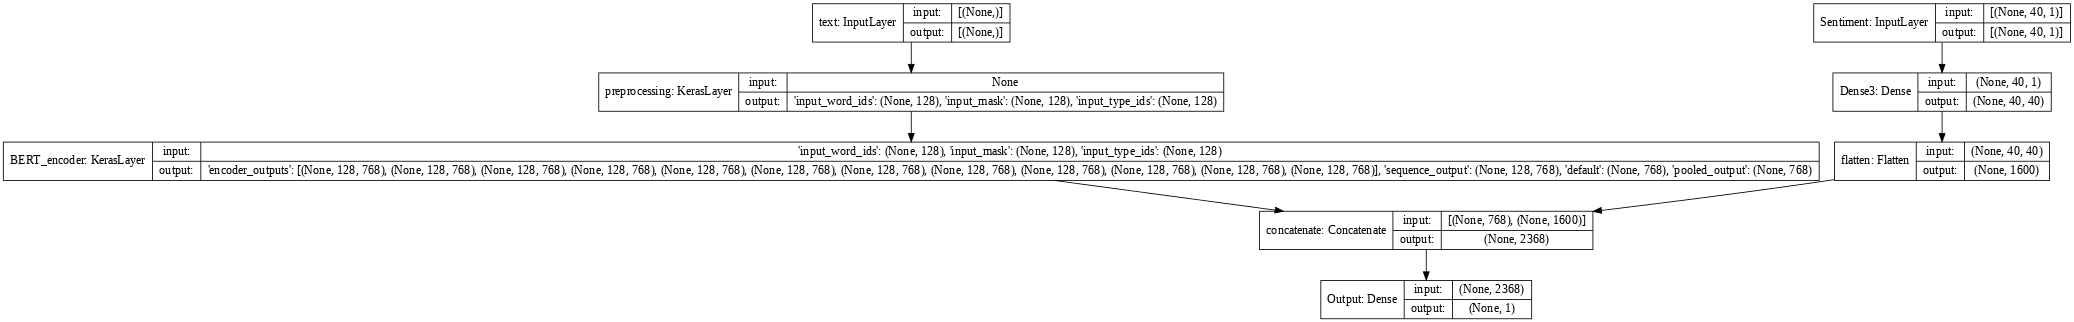

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=60 )

### Set Parameters

In [ ]:
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5
opt = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

In [ ]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1, restore_best_weights=True)

### Training

In [ ]:
#history = model.fit(x=train_data, epochs=epochs, validation_data=valid_data, callbacks=[checkpoint_cb, early_stopping_cb])

history = model.fit((train_data, train_sent), train_df['label'], validation_data=((valid_data, valid_sent), valid_df['label']), callbacks=[checkpoint_cb, early_stopping_cb])

ValueError: ignored

In [ ]:
model.save("/content/drive/MyDrive/model.h5")
print("Saved model to disk")

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
plot_graphs(history, 'loss')

### Testing-1

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_df[column_].values, test_df['label'].values))
predicted = model.predict([test_df[column_]])
pred=[1 if p >=0.5 else 0 for p in predicted]
from pandas import DataFrame
pred_df = DataFrame (pred,columns=['pred_label'])
true_label = test_df["label"]
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
accuracy_score(true_label,pred_df),precision_score(true_label,pred_df),recall_score(true_label,pred_df),f1_score(true_label,pred_df)


In [ ]:
"""from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_label, pred_df)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()"""

In [ ]:
"""from sklearn.metrics import roc_auc_score
roc_auc_score(true_label, pred_df)"""